<a href="https://colab.research.google.com/github/Snehal-Reddy/NeuralNetPruning/blob/master/WeightBasedPruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import keras
tf.enable_eager_execution()

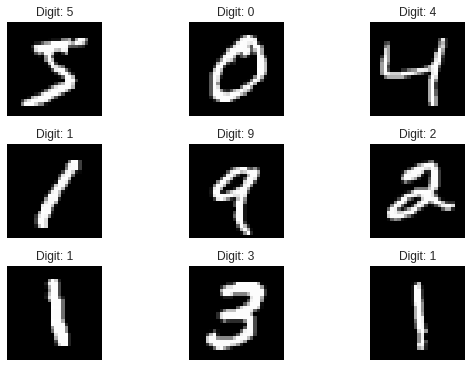

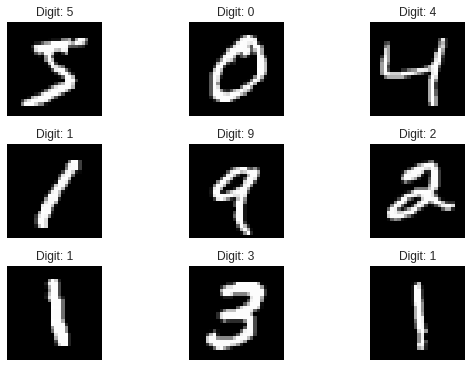

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# features, labels = next(iter(mnist))

fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [0]:
dataset_train = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train/255, tf.float32),
    tf.cast(y_train, tf.int64)
)).shuffle(1000).batch(64)

dataset_test = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_test/255, tf.float32),
    tf.cast(y_test, tf.int64)
)).batch(64)

In [4]:
naive_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(10, use_bias=False)
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def loss(naive_model, x, y):
    y_ = naive_model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

In [0]:
def grad(naive_model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(naive_model, inputs, targets)
    return loss_value, tape.gradient(loss_value, naive_model.trainable_variables)

In [0]:
optimizer = tf.train.AdamOptimizer()
global_step = tf.train.get_or_create_global_step()

In [10]:
from tensorflow import contrib
tfe = contrib.eager

train_loss_results = []
train_accuracy_results = []

epoch_num = 5

for epoch in range(epoch_num):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    for x, y in (dataset_train):
        outputs = naive_model(x)
        loss_value, grads = grad(naive_model, x, y)
        optimizer.apply_gradients(zip(grads, naive_model.trainable_variables),global_step)  
        
        epoch_loss_avg(loss_value)  
#         epoch_accuracy(tf.argmax(naive_model(x), axis=1, output_type=tf.int32), y)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
        
#         with tf.GradientTape() as tape:
#             outputs = model(x)
#             loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
#         grads = tape.gradient(loss, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights), global_step)
#         epoch_loss_avg(loss)
#         epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
#     training_losses.append(epoch_loss_avg.result())
#     training_accuracies.append(epoch_accuracy.result())

Epoch 000: Loss: 0.021, Accuracy: 99.370%


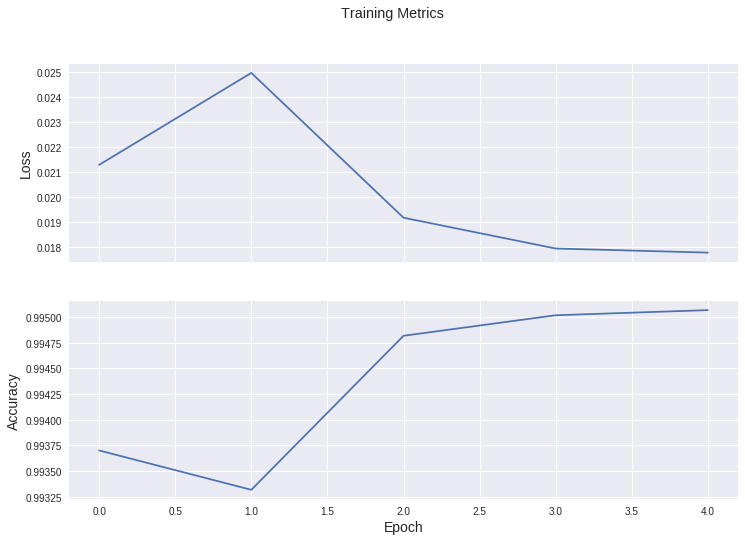

In [11]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

In [0]:
 def test(model, data_test):  
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    for x, y in dataset_test:
        outputs = model(x)
        loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
        epoch_loss_avg(loss)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    result = epoch_loss_avg.result().numpy(), epoch_accuracy.result().numpy()
    return result


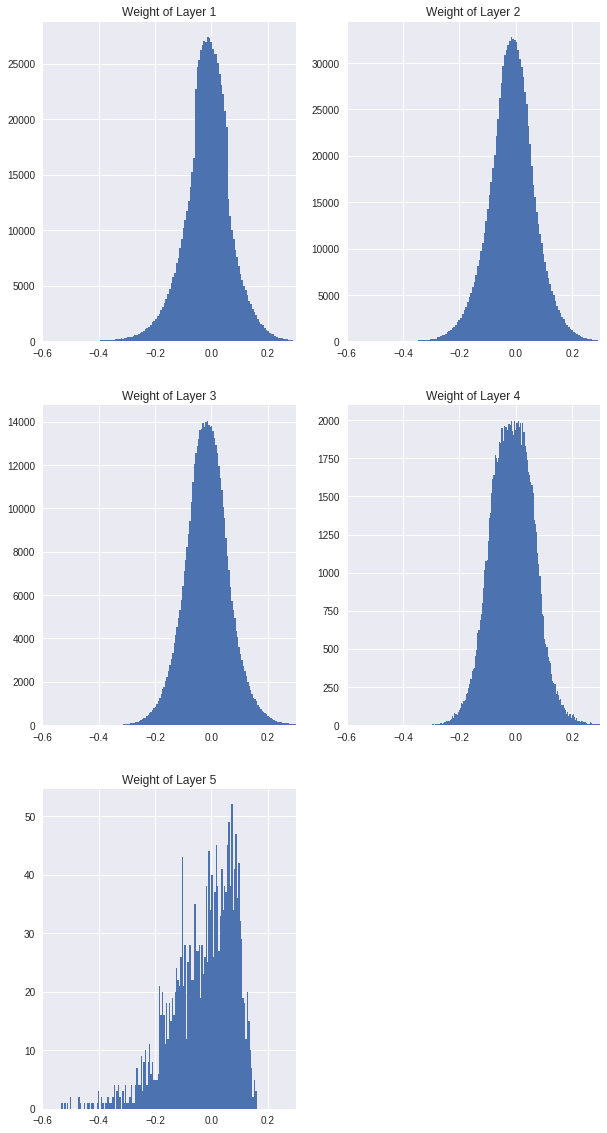

In [46]:
for i, weights in enumerate(naive_model.trainable_weights):
    plt.figure(1, figsize=(10,20),facecolor = 'white',edgecolor = 'r')
    plt.subplot(3,2,i+1)
    plt.title("Weight of Layer {}".format(i+1))
    plt.hist(weights.numpy().reshape(-1), bins=200)
    plt.xlim(-0.6, 0.3);

In [0]:
import time
list_percentile = [0,1,5,10,15,25,50,75]



In [68]:
class WeightSparseModel():
    def __init__(self, sparsify=True):
        self.sparsify = sparsify
        self.flatten = tf.layers.Flatten()
        self.weights = []
        
    def add_layer(self, weights):
        if self.sparsify:
            weights = tf.contrib.layers.dense_to_sparse(weights)
        self.weights.append(weights)
        
    def __call__(self, dense_x):
        dense_x = self.flatten(dense_x)
        # Sparse matrix multiplication requires the sparse matrix
        # to be the left operand. As such, we reorder operations
        # when sparsified:
        # relu(X x sL1) x sL2 == (sL2^T x relu(sL1^T x X^T))^T
        if self.sparsify:
            dense_x = tf.transpose(dense_x) # X^T
        for i, weights in enumerate(self.weights):
            if self.sparsify:
                dense_x = tf.sparse.matmul(weights, dense_x, adjoint_a=True) # sL^T x X^T
            else:
                dense_x = tf.matmul(dense_x, weights)
            # Apply ReLU to hidden outputs only
            if i < len(self.weights)-1:
                dense_x = tf.nn.relu(dense_x)
        if self.sparsify:
            dense_x = tf.transpose(dense_x) # X == (X^T)^T
        return dense_x

def prune_weights(dense_model, percentile, sparsify=True):
    sparse_model = WeightSparseModel(sparsify)
    num_layers = len(dense_model.trainable_weights)

    for i_layer, weights in enumerate(dense_model.trainable_weights):
        weights_np = weights.numpy()
        
        # Zero out pruned weights
        if i_layer < num_layers-1: # Do not prune last layer
            critical_value = np.percentile(np.abs(weights_np), percentile)
            zero_mask = np.abs(weights_np) < critical_value
            weights_np[zero_mask] = 0
        # Add new layer to sparse model
        sparse_model.add_layer(tf.convert_to_tensor(weights_np))

    return sparse_model

test(prune_weights(naive_model, 90), dataset_test) # Sanity check

(0.8109530962196885, 0.9352)

In [71]:
pruned_weight_test_losses = []
pruned_weight_test_accuracies = []
pruned_weight_sparse_timings = []
pruned_weight_timings = []

for percentile in list_percentile:
    sparsified_model = prune_weights(naive_model, percentile, True)
    t1 = time.clock()
    l, a = test(sparsified_model, dataset_test)
    t1 = time.clock() - t1

    pruned_model = prune_weights(naive_model, percentile, False)
    t2 = time.clock()
    l2, a2 = test(pruned_model, dataset_test)
    t2 = time.clock() - t2
    
    # Sanity check - both weight pruning methods return same results
    np.testing.assert_almost_equal(l, l2)
    np.testing.assert_almost_equal(a, a2)
    
    print(f"Pruning p{percentile} -- Test Loss: {l:.4f}, Test Accuracy: {a:.4f}, Sparse Timing Ratio: {(t1/t2):.2f} ({t1:.2f}s/{t2:.2f}s)")
    pruned_weight_test_losses.append(l)
    pruned_weight_test_accuracies.append(a)
    pruned_weight_sparse_timings.append(t1)
    pruned_weight_timings.append(t2)

Pruning p0 -- Test Loss: 0.0971, Test Accuracy: 0.9837, Sparse Timing Ratio: 12.04 (33.95s/2.82s)
Pruning p1 -- Test Loss: 0.0971, Test Accuracy: 0.9837, Sparse Timing Ratio: 12.61 (33.63s/2.67s)
Pruning p5 -- Test Loss: 0.0971, Test Accuracy: 0.9837, Sparse Timing Ratio: 12.04 (32.24s/2.68s)
Pruning p10 -- Test Loss: 0.0968, Test Accuracy: 0.9837, Sparse Timing Ratio: 11.11 (30.66s/2.76s)
Pruning p15 -- Test Loss: 0.0966, Test Accuracy: 0.9838, Sparse Timing Ratio: 10.70 (28.99s/2.71s)
Pruning p25 -- Test Loss: 0.0957, Test Accuracy: 0.9839, Sparse Timing Ratio: 9.67 (25.71s/2.66s)
Pruning p50 -- Test Loss: 0.0837, Test Accuracy: 0.9841, Sparse Timing Ratio: 6.22 (17.39s/2.80s)
Pruning p75 -- Test Loss: 0.0834, Test Accuracy: 0.9803, Sparse Timing Ratio: 3.25 (9.08s/2.79s)
